In [12]:
from scipy.integrate import solve_ivp
import scipy.linalg as la
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [13]:
def make_stiffness_matrix(n, mod_elas, mom_inertia, length):
    k_matrix = np.array([
        [
            12*mod_elas*mom_inertia/(length/n)**3,
            6*mod_elas*mom_inertia/(length/n)**2,
            -12*mod_elas*mom_inertia/(length/n)**3,
            6*mod_elas*mom_inertia/(length/n)**2
        ],
        [
            6*mod_elas*mom_inertia/(length/n)**2,
            4*mod_elas*mom_inertia/(length/n),
            -6*mod_elas*mom_inertia/(length/n)**2,
            2*mod_elas*mom_inertia/(length/n)
        ],
        [
            -12*mod_elas*mom_inertia/(length/n)**3,
            -6*mod_elas*mom_inertia/(length/n)**2,
            12*mod_elas*mom_inertia/(length/n)**3,
            -6*mod_elas*mom_inertia/(length/n)**2
        ],
        [
            6*mod_elas*mom_inertia/(length/n)**2,
            2*mod_elas*mom_inertia/(length/n),
            -6*mod_elas*mom_inertia/(length/n)**2,
            4*mod_elas*mom_inertia/(length/n)
        ]
    ])

    stiffness_matrix = np.zeros((2*n + 2, 2*n + 2), dtype='float')
    i, j = 0, 0
    counti, countj = 0, 0

    while i < 2*n + 2:
        while j < 2*n + 2:
            stiffness_matrix[i][j] += k_matrix[counti][countj]
            j += 1
            countj += 1
            if countj == 4:
                if counti != 3:
                    i += 1
                    countj = 0
                    j -= 4
                    counti += 1
                    continue
                if counti == 3:
                    if i == 2*n + 1:
                        break
                    j -= 2
                    i -= 1
                    counti, countj = 0, 0
        break
    
    stiffness_matrix = np.delete(stiffness_matrix, np.s_[0:2], 0)
    stiffness_matrix = np.delete(stiffness_matrix, np.s_[0:2], 1)

    return stiffness_matrix


def make_mass_matrix(n, area, density, length):

    mass_matrix = np.zeros((2*n + 2, 2*n + 2), dtype='float')

    m_matrix = np.array([
        [
            13*area*(length/n)*density/35,
            11*area*((length/n)**2)*density/210,
            9*area*(length/n)*density/70,
            -13*area*((length/n)**2)*density/420
        ],
        [
            11*area*((length/n)**2)*density/210,
            area*((length/n)**3)*density/105,
            13*area*((length/n)**2)*density/420,
            -area*((length/n)**3)*density/140
        ],
        [
            9*area*(length/n)*density/70,
            13*area*((length/n)**2)*density/420,
            13*area*(length/n)*density/35,
            -11*area*((length/n)**2)*density/210
        ],
        [
            -13*area*((length/n)**2)*density/420,
            -area*((length/n)**3)*density/140,
            -11*area*((length/n)**2)*density/210,
            area*((length/n)**3)*density/105
        ]
    ])

    i, j = 0, 0
    counti, countj = 0, 0

    while i < 2*n + 2:
        while j < 2*n + 2:
            mass_matrix[i][j] += m_matrix[counti][countj]
            j += 1
            countj += 1

            if countj == 4:
                if counti != 3:
                    i += 1
                    countj = 0
                    j -= 4
                    counti += 1
                    continue
                if counti == 3:
                    if i == 2*n + 1:
                        break
                    j -= 2
                    i -= 1
                    counti, countj = 0, 0

        break

    mass_matrix = np.delete(mass_matrix, np.s_[0:2], 0)
    mass_matrix = np.delete(mass_matrix, np.s_[0:2], 1)

    return mass_matrix


def plot_graphs(x_value, y_values, x_axis_label, y_axis_label, graph_title, fig_length=20, fig_height=9):
    plt.figure(figsize=(fig_length, fig_height))
    plt.plot(x_value, y_values, linewidth=0.8, color = 'black')
    plt.title(graph_title)
    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)
    plt.show()






In [14]:
def ode(t, y, n, a, b, forces, freq, amplitude, type):

    forces[-2] = amplitude*type(2*np.pi*freq*t)

    yvec = np.array([[y[i] for i in range(4*n)]]).T

    yvec1 = np.matmul(a, yvec) + np.matmul(b, forces)
    yvec2 = np.matmul(a, yvec) + np.matmul(b, forces)

    return yvec1

In [15]:
number = 10                     # number of elements taken
length_of_beam = 5              # in meters
breadth_of_beam = 0.05          # in meters
height_of_beam = 0.05           # in meters
modulus_of_elasticity = 7E10    # in   
density_of_beam = 2700  

In [16]:
cross_sect_area = breadth_of_beam*height_of_beam
area_mom_inertia = (breadth_of_beam*height_of_beam**3)/12
global_stiffness_matrix = make_stiffness_matrix(number, modulus_of_elasticity, area_mom_inertia, length_of_beam)
global_mass_matrix = make_mass_matrix(number, cross_sect_area, density_of_beam, length_of_beam)
evals, evecs = la.eigh(global_stiffness_matrix, global_mass_matrix)
frequencies = np.sqrt(evals)/(2*np.pi)
print("The first 5 frequencies are : ", frequencies[:5])

The first 5 frequencies are :  [ 1.64504494 10.30965305 28.87372123 56.62047282 93.7443023 ]


In [17]:
start_time = 0
end_time = 4
time_step = 1/2000

freq = frequencies[0]
force_amplitude = 4
force_type = np.sin

spring_stiffness = 9

In [18]:
damping = np.zeros((2*number, 2*number))
A = np.vstack([
    np.hstack([
        np.zeros((2*number, 2*number)), 
        np.eye(2*number, 2*number)
    ]), 
    np.hstack([
        -np.matmul(np.linalg.inv(global_mass_matrix), global_stiffness_matrix), 
        -np.matmul(np.linalg.inv(global_mass_matrix), damping)
    ])
])
B = np.vstack([
    np.zeros((2*number, 2*number)), 
    np.linalg.inv(global_mass_matrix)
])

vertical_forces = np.zeros(2*number)

initial_conditions = np.zeros(4*number)

time_vector = np.arange(start_time, end_time, time_step)
time_interval = np.array([start_time, end_time])

spring_matrix = np.zeros(2*number)

spring_matrix[number ]
sol = solve_ivp(ode, time_interval, initial_conditions, t_eval = time_vector, vectorized=True, args = (number, A, B, vertical_forces, freq, force_amplitude, force_type)) 
total_beam_displacement = sol.y


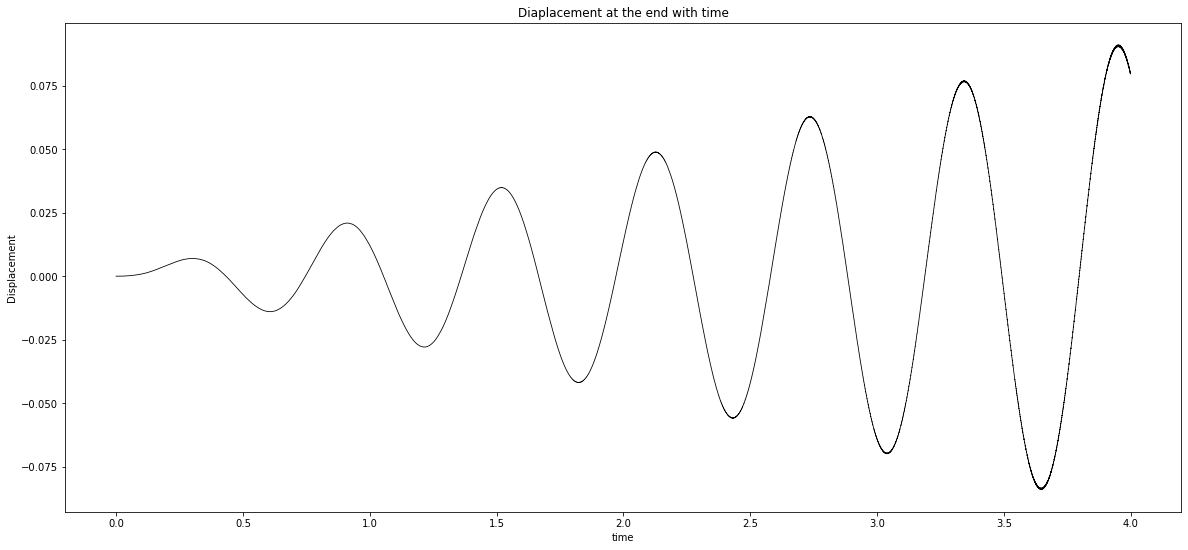

In [20]:
plot_graphs(time_vector, total_beam_displacement[2*number - 2], 'time', 'Displacement', 'Diaplacement at the end with time')


In [5]:
import numpy as np
a = np.zeros((4, 1))
print(a[0][0])

0.0


In [8]:
a = np.zeros(3)
print(a)
b = np.zeros((3, 1))
print(b)

[0. 0. 0.]
[[0.]
 [0.]
 [0.]]
